core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


2023 Season Round 10: British Grand Prix - Qualifying


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


0                        NaT
1     0 days 00:00:28.534000
2     0 days 00:00:28.441000
3     0 days 00:00:48.387000
4     0 days 00:00:28.109000
               ...          
381   0 days 00:00:28.811000
382   0 days 00:00:42.982000
383   0 days 00:00:28.284000
384   0 days 00:00:47.151000
385   0 days 00:00:28.585000
Name: Sector1Time, Length: 386, dtype: timedelta64[ns]
0      SOFT
1      SOFT
2      SOFT
3      SOFT
4      SOFT
       ... 
381    SOFT
382    SOFT
383    SOFT
384    SOFT
385    SOFT
Name: Compound, Length: 386, dtype: object
Data types after conversion:
S1         float64
S2         float64
S3         float64
LapTime    float64
dtype: object
R² score: 1.000
Mean Absolute Error: 0.000 seconds


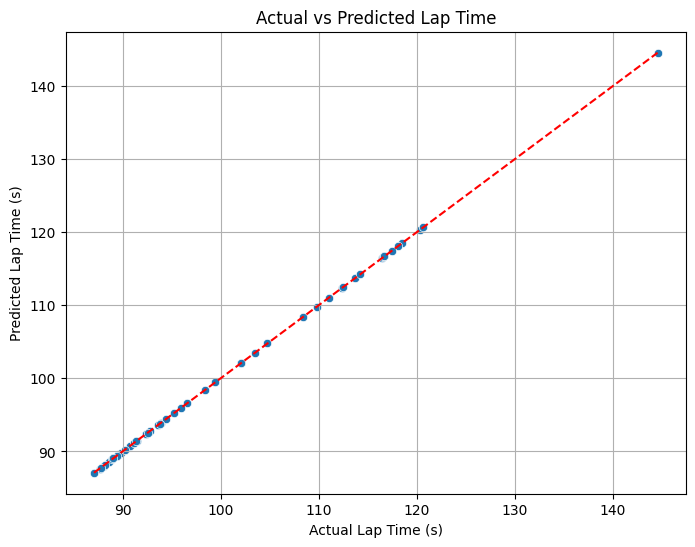

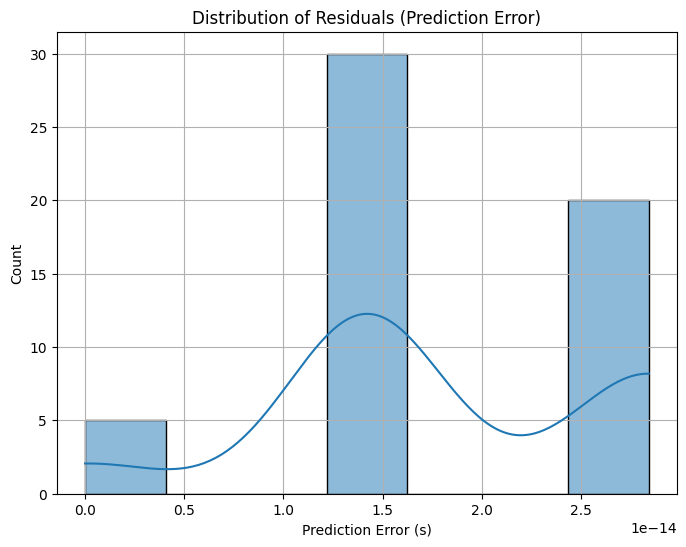

In [ ]:
import fastf1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# # Enable FastF1 cache
fastf1.Cache.enable_cache('../cache')

# load qualifying data
session  = fastf1.get_session(2023, 'Silverstone', 'Q')
print(session)
session.load()

# prepare data using same logic from your preprocess.py
laps = session.laps
print(laps['Sector1Time'])
print(laps['Compound'])

# define a mapping for tire compounds
# creates a dictionary that converts categorical tire compounds to numerical values
compound_map = {'SOFT': 0, 'MEDIUM': 1, 'HARD': 2}

# apply the mapping to create a new column 'CompoundEncoded'
# this will convert the 'Compound' column to numerical values based on the mapping
laps['CompoundEncoded'] = laps['Compound'].map(compound_map)

# Convert Timedelta to seconds before doing the analysis
# Each F1 track is divided into three sectors:
# Sector 1 (S1): Start of the lap --> first time marker
# Sector 2 (S2): Middle of the lap
# Sector 3 (S3): End of the lap or last portion --> ends at finish line
# example Sector3Time         S3
#         00:00:25.876    →   25.876
# 
laps['S1'] = laps['Sector1Time'].dt.total_seconds()
laps['S2'] = laps['Sector2Time'].dt.total_seconds()
laps['S3'] = laps['Sector3Time'].dt.total_seconds()
laps['LapTime'] = laps['LapTime'].dt.total_seconds()
#  Machine learning algorithms can't work with categorical data (tire compounds), models can't work with dimedelta objects(need numerical values). The dt.total_seconds() method converts
# pandas timedelta objects to numerical values (seconds), which is suitable for machine learning models.
# this makes the data ready for mathematical operations and model training


# Rest of your code remains the same
# Drop rows with NaN values in the specified columns
# This ensures that the model is trained only on complete data
laps = laps.dropna(subset=['S1', 'S2', 'S3', 'TyreLife', 'CompoundEncoded', 'LapTime'])

# Select relevant columns for the model
# This creates a new DataFrame with only the necessary features and target variable
data = laps[["S1", "S2", "S3", "TyreLife", "CompoundEncoded", "LapTime"]]

# Add this after the conversion to verify data types
print("Data types after conversion:")
print(laps[["S1", "S2", "S3", "LapTime"]].dtypes)

# traing model and evaluate
# feature matrix X and target variable y
X= data[["S1", "S2", "S3", "TyreLife", "CompoundEncoded"]]
y= data["LapTime"]

# Split the data into training and testing sets
# This separates the data into two parts: one for training the model and one for testing its performance
# This is a common practice in machine learning to evaluate how well the model generalizes to unseen data
# X features (S1, S2, S3, TyreLife, CompoundEncoded), which is a matrix of input features
# y target variable (LapTime), which is a vector of output values
# the test_size parameter specifies the proportion of the dataset to include in the test split (0.2 means 20% for testing, 80% for training)
# X_train - 80% of features for training
# X_test  - 20% of features for testing
# y_train - 80% of lap times for training
# y_test  - 20% of lap times for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² score: {score:.3f}")
print(f"Mean Absolute Error: {mae:.3f} seconds")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Actual vs Predicted Lap Time")
plt.grid(True)
plt.show()


residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (Prediction Error)")
plt.xlabel("Prediction Error (s)")
plt.grid(True)
plt.show()



